In [50]:
import numpy as np
import pandas as pd 
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

def heatmap(df,labels):

    cm = np.corrcoef(df[labels].dropna().values.T)
    sns.set(font_scale = 1)
    hm = sns.heatmap( cm
                    ,cbar = True
                    ,annot = True
                    ,square = True
                    ,fmt = '.2f'
                    )
    hm.set_xticklabels(labels,rotation = 90)
    hm.set_yticklabels(labels[::-1],rotation = 0)
    
    return hm,cm

In [51]:
frame = pd.read_csv("train.csv")
#There appears to be a lot of null values in the following columns
#so we'll drop these for the time being. I always take a peak using print(frame.info())
frame.drop(['Alley'
            ,'FireplaceQu'
            ,'PoolQC'
            ,'Fence'
            ,'MiscFeature'
            ]
            , axis=1
            , inplace=True)

#I'm going to split out the different data types separately and analyse the 
#float and integer variables.
g = frame.columns.to_series().groupby(frame.dtypes).groups
grpdict = {k.name: v for k, v in g.items()}

#Categorical variables are those labelled object
categorical = grpdict['object']

#Float variables and we'll add the target variable for comparison
floatVars = grpdict['float64']
floatVars.append('SalePrice')

#There are quite a few integer variables, too many for a pairplot
#so I'll subdivide into 5 lists.
intVars = grpdict['int64']
list_intVars = np.split(np.array(intVars),7)
list_intVars = [np.append(l,'SalePrice') for l in list_intVars]

dummies = pd.get_dummies(frame[categorical]).columns.values.tolist()
frame = pd.get_dummies(frame)

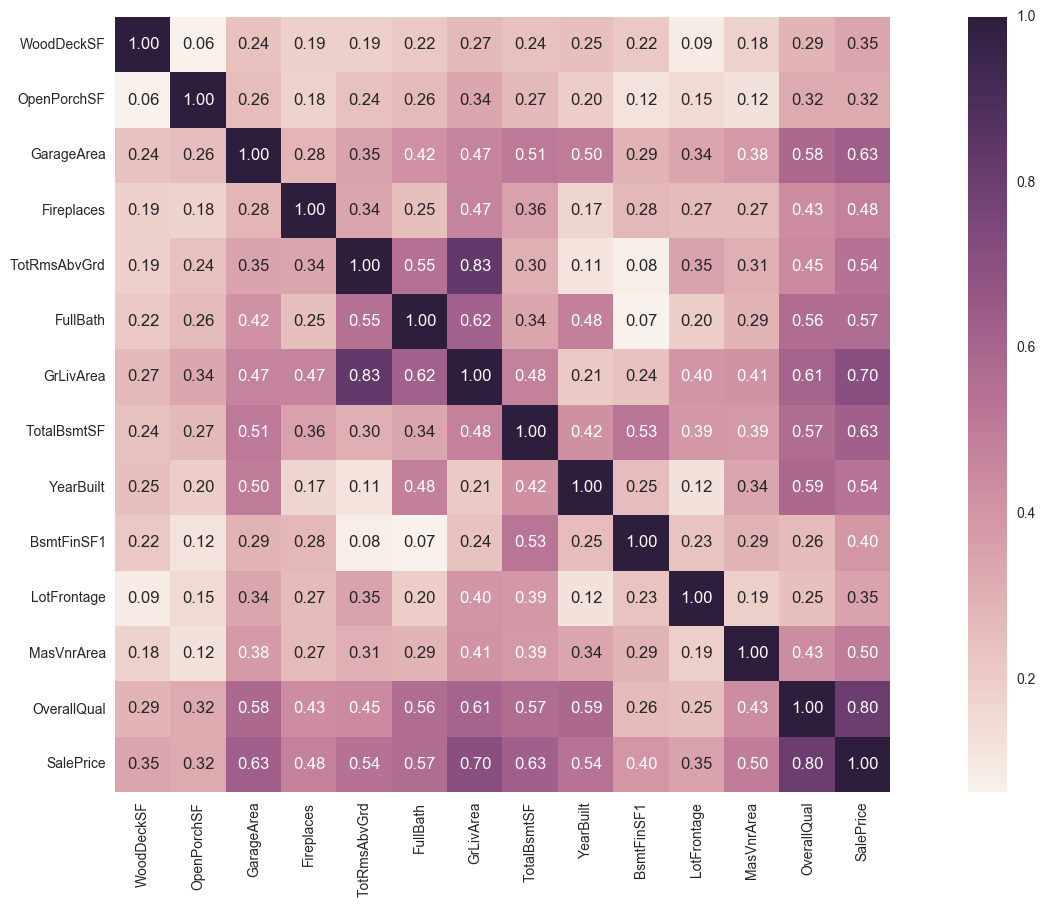

In [52]:
#There are a fair few variables so I split the interger variables
#into five groups as above and looked through them manually and pulled
#out the most correlated features from the float and integer variables.

corrfeats = [
             'WoodDeckSF'
            ,'OpenPorchSF'
            ,'GarageArea'#
            ,'Fireplaces'
            ,'TotRmsAbvGrd'
            ,'FullBath'
            ,'GrLivArea'#
            ,'TotalBsmtSF'#
            ,'YearBuilt'
            ,'BsmtFinSF1'
            ,'LotFrontage'
            ,'MasVnrArea'
            ,'OverallQual'#
            ,'SalePrice'
            ]

plt.figure(figsize = (20,10))
htmp,corrm = heatmap(frame,corrfeats)

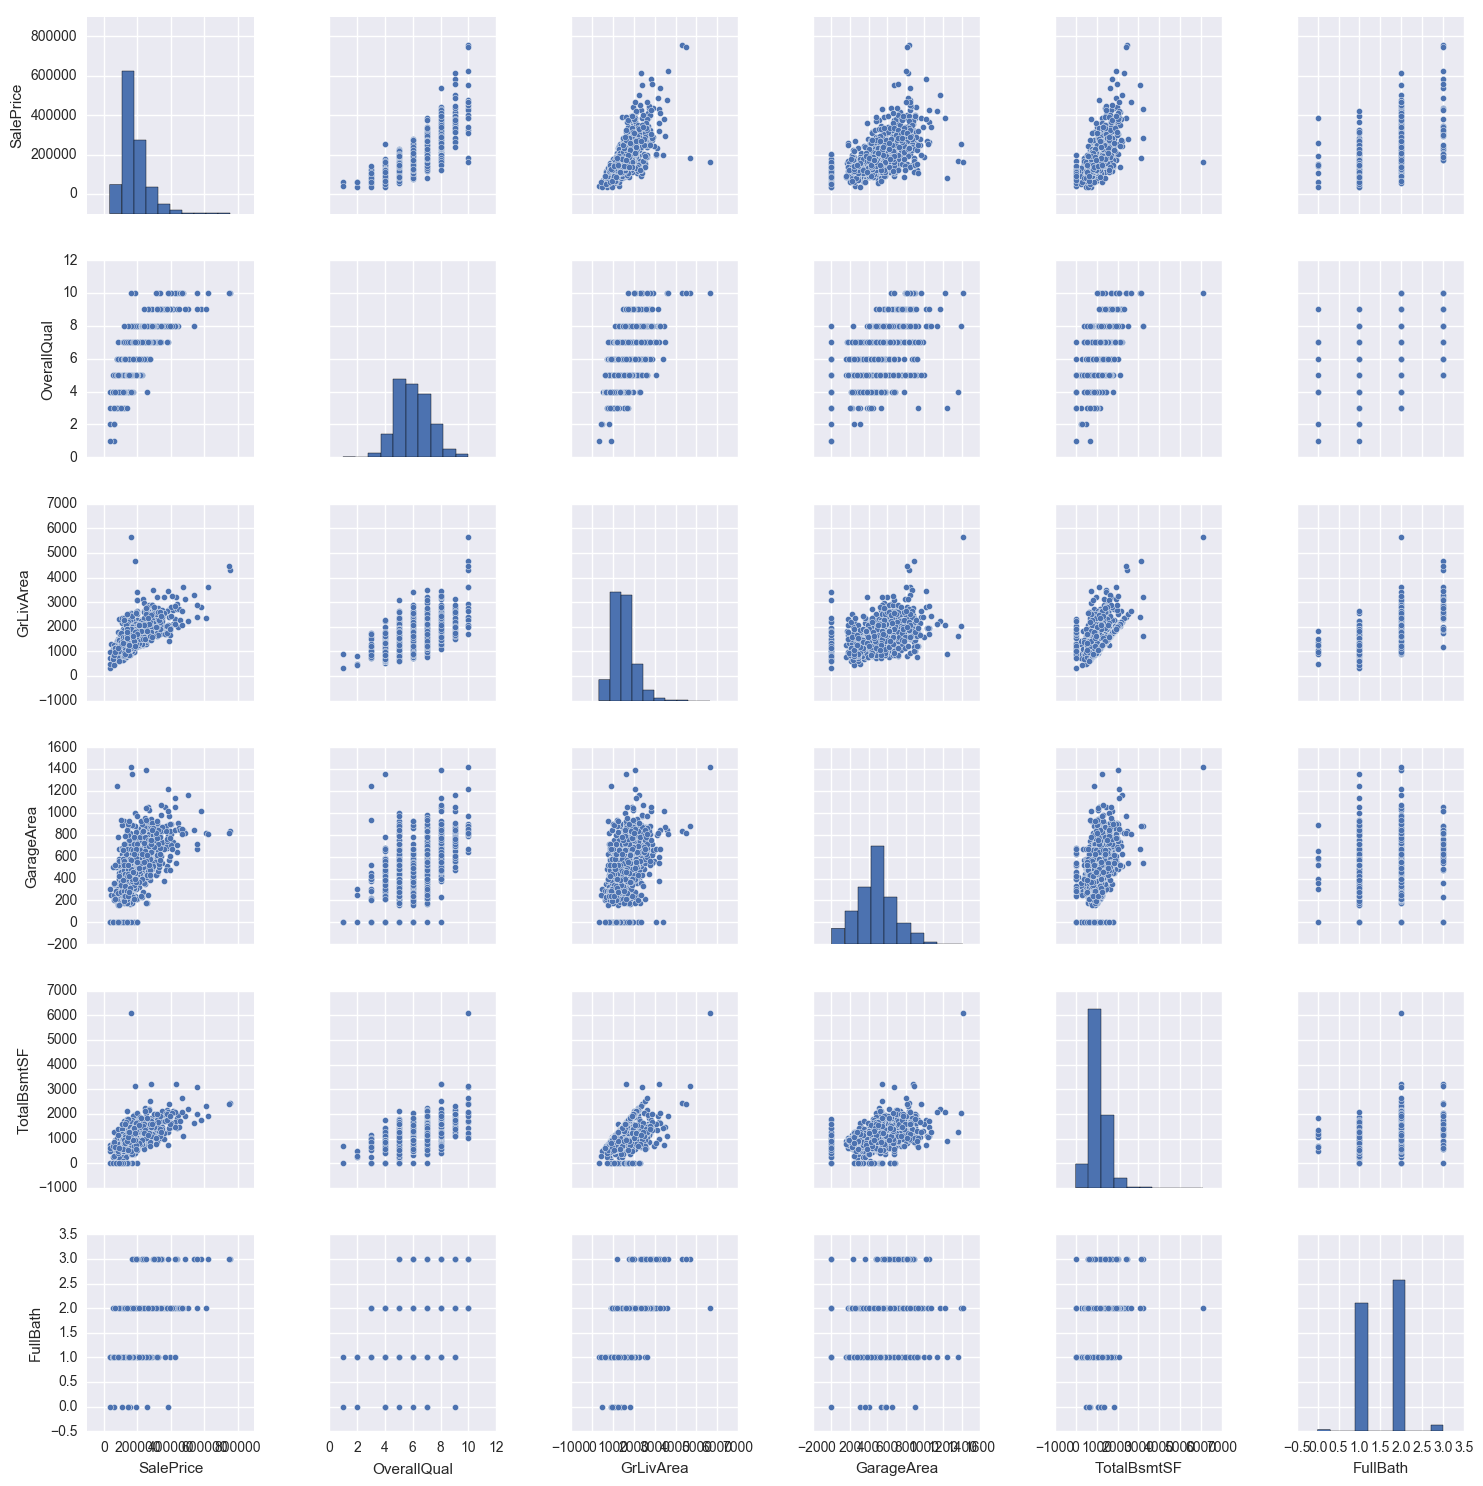

In [53]:
#I've pulled out the top 5 most correlated features.
feats = [x for (y,x) in sorted(zip(corrm[-1],corrfeats),reverse = True)]
sns.pairplot(frame[feats[0:6]].dropna())
plt.tight_layout()

#After running the features through the model, the following
#had very small coefficients and weren't contributing to a 
#reduction in the testing score.
feats.remove('MasVnrArea')
feats.remove('FullBath')
feats.remove('TotRmsAbvGrd')

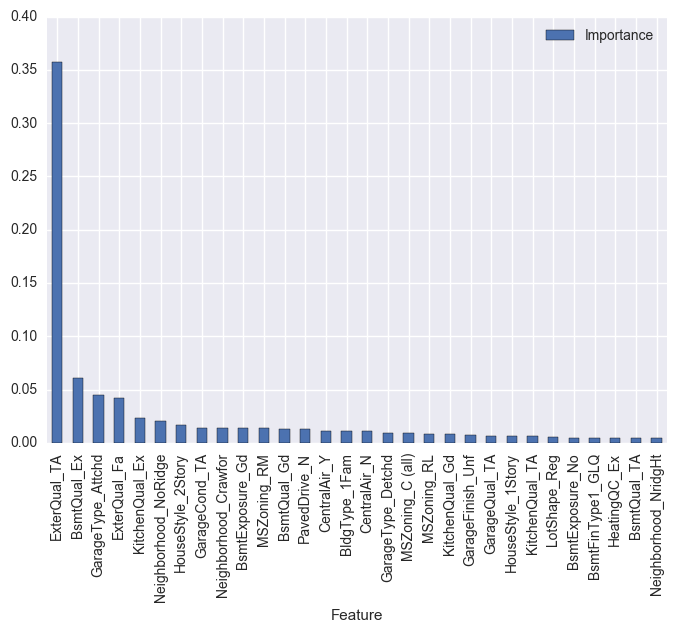

In [54]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100)
rf.fit(frame[dummies],frame['SalePrice'].apply(np.log1p))

frameFeats = pd.DataFrame(data = None,columns=['Feature','Importance'])
frameFeats['Feature'] = dummies
frameFeats['Importance'] = rf.feature_importances_
frameFeats.sort_values('Importance',ascending = False).head(30).plot(x = 'Feature'
                                                                   , y = 'Importance'
                                                                   ,kind = 'bar')
top = frameFeats.sort_values('Importance',ascending = False)
dummyFeats = top['Feature'].values.tolist()

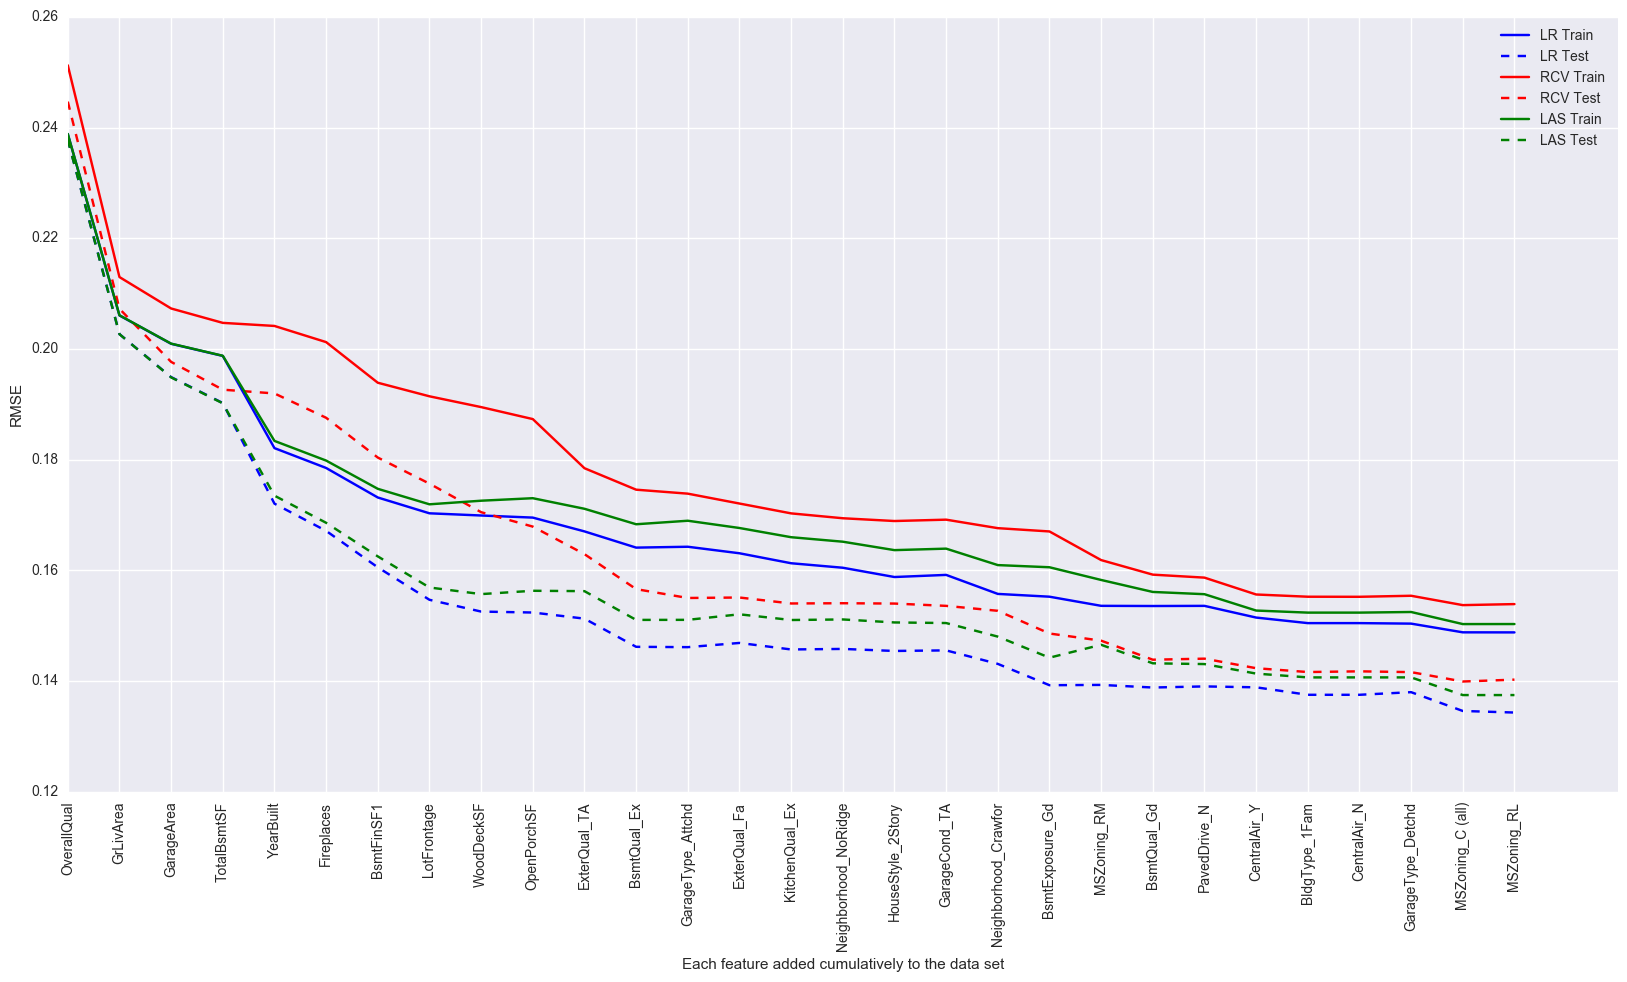

In [55]:
#Comparing some 'simple' linear models, linear regression
#Ridge regression and Lasso to see what effect regulisation has
#on the final solution of these techniques
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

def feattest(model,tfeats,Xtrain,xtest,Ytrain,ytest):
    """
    Testing the features one by one and scoring the
    models on the test and training set.
    
    """
    trainscrs = []
    testscrs = []
    for i in range(1,len(tfeats)+1):
        X_t = Xtrain[tfeats[0:i]]
        x_t = xtest[tfeats[0:i]]
        model.fit(X_t,Ytrain)
        trainscrs.append(
                         np.sqrt(
                                 -cross_val_score(
                                                  model, 
                                                  X_t, 
                                                  Ytrain, 
                                                  scoring="neg_mean_squared_error", 
                                                  cv = 5
                                                 )
                                ).mean()
                        )
        testscrs.append(np.sqrt(mean_squared_error(ytest,model.predict(x_t))))
    return trainscrs,testscrs,model

def dataprep(df,numFeats,dumFeats):
    """
    Preparation of the data: Log transform numerical variables
    and join on the dummy variables for the categorical features.
    Simple mean filling applied for missing values.
    
    """
    df_t = df[numFeats].fillna(df[numFeats].mean()).apply(np.log1p)
    df_t = df_t.join(df[dumFeats])
    return df_t

lr = LinearRegression()
rcv = RidgeCV(
                alphas=[10,100,1000]
              , scoring="neg_mean_squared_error"
              , store_cv_values = True
             )
las = LassoCV(cv = 10)

#Fill with the mean of each column and log transform the 
#numerical features
modelData = dataprep(frame,feats,dummies)

#Add the 10 most important categorical features to the train and
#test sets
tf = feats[1:] + dummyFeats[0:20] 

X,x,Y,y = train_test_split(
                            modelData[tf]
                           ,modelData['SalePrice']
                           ,test_size = 0.33
                           ,random_state = 23
                          )

trainlr,testlr,lr = feattest(lr,tf,X,x,Y,y)
trainrcv,testrcv,rcv = feattest(rcv,tf,X,x,Y,y)
trainlas,testlas,las = feattest(las,tf,X,x,Y,y)

#Select the minimum, currently based on the linear regression
#model.
lastFeat = np.argmin(testlr)

fig_f = plt.subplots(figsize = (20,10))
plt.plot(trainlr[0:lastFeat],'b',label = 'LR Train')
plt.plot(testlr[0:lastFeat],'b--',label = 'LR Test')
plt.plot(trainrcv[0:lastFeat],'r',label = 'RCV Train')
plt.plot(testrcv[0:lastFeat],'r--',label = 'RCV Test')
plt.plot(trainlas[0:lastFeat],'g',label = 'LAS Train')
plt.plot(testlas[0:lastFeat],'g--',label = 'LAS Test')
plt.xlabel('Each feature added cumulatively to the data set')
plt.ylabel('RMSE')
plt.xticks(range(0,len(tf[0:lastFeat])),tf[0:lastFeat],rotation = 'vertical')
plt.legend(loc = 1)

finalFeats = tf[0:lastFeat]
finalNumerical = feats[1:]
finalDummy = list(set(finalFeats) - set(finalNumerical))

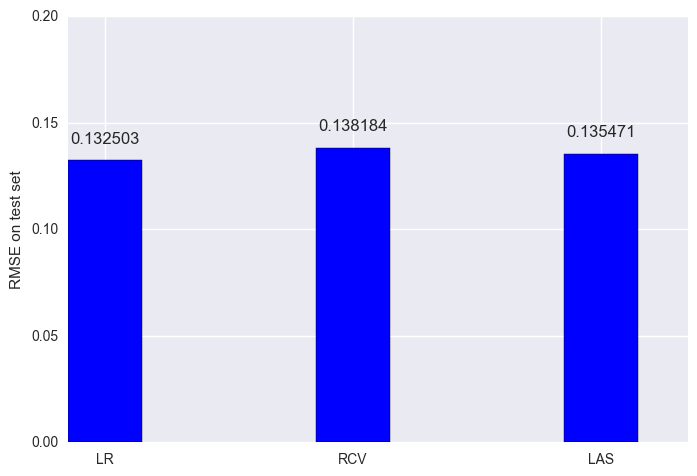

In [56]:
def autolabel(rects):
    # attach some text labels
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%f' % float(height),
                ha='center', va='bottom')

minscrs = [min(testlr),min(testrcv),min(testlas)]
labels = ['LR','RCV','LAS']

ind_scrs = np.arange(0,len(minscrs))
width = 0.3
fig, ax = plt.subplots()
rects = ax.bar(ind_scrs, minscrs, width, color = 'b')
ax.set_xticks(np.array(ind_scrs) + width/2)
ax.set_xticklabels(labels)
ax.set_ylabel('RMSE on test set')
ax.set_ylim([0,0.2])
autolabel(rects)

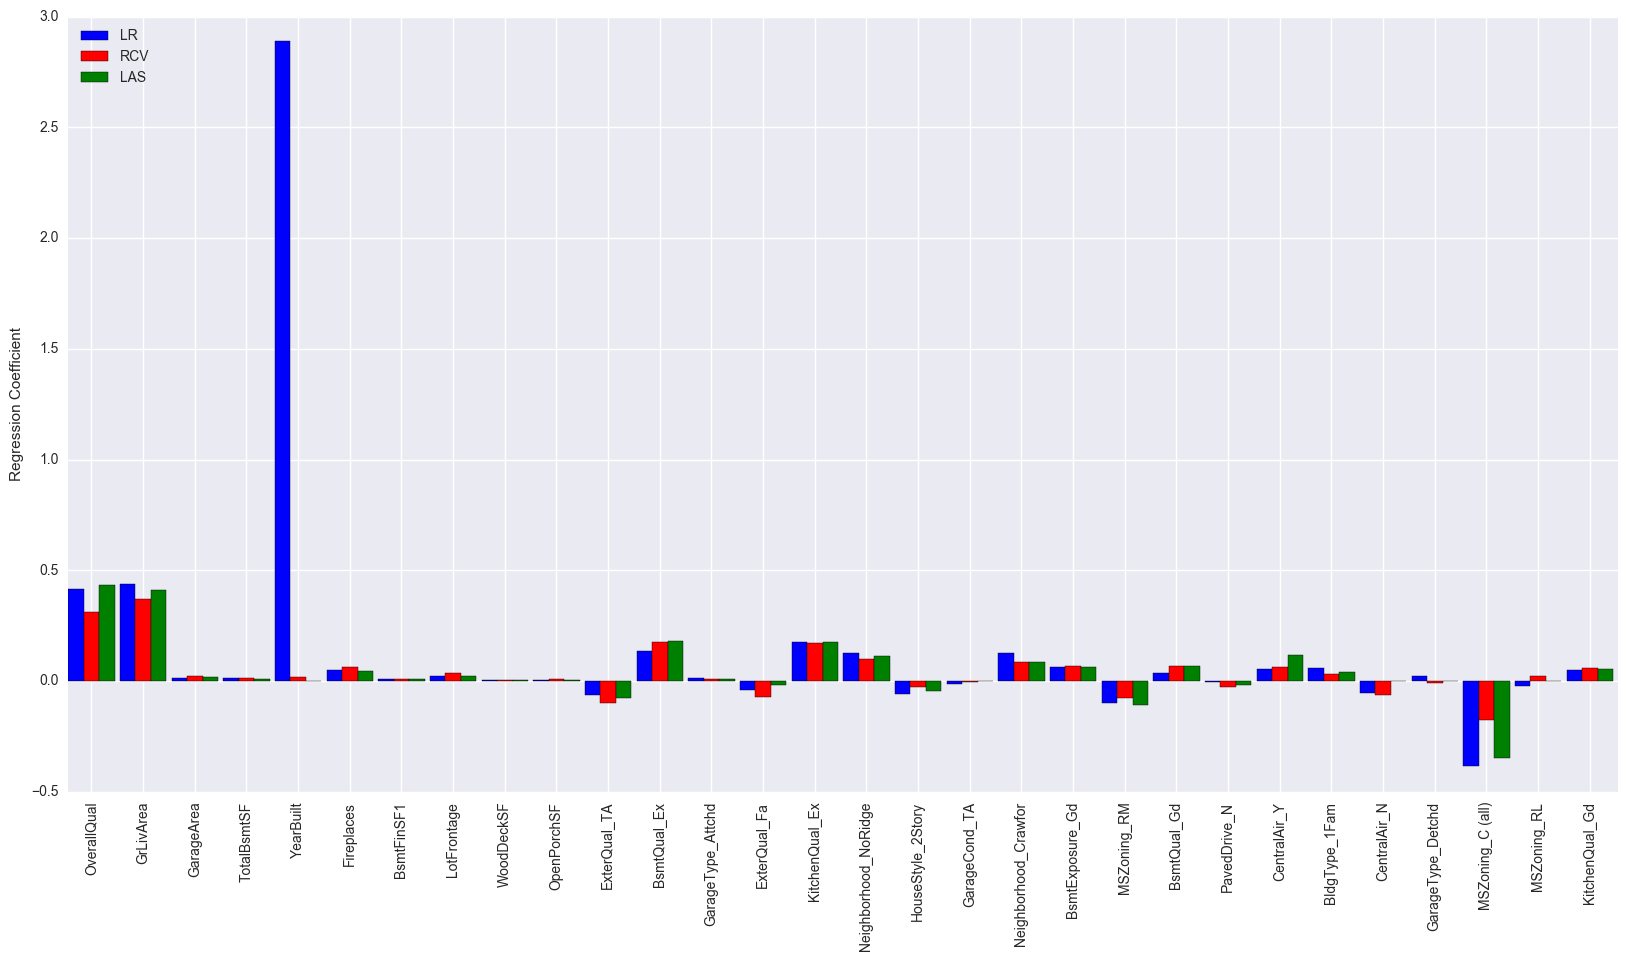

In [57]:
ind = np.arange(0,len(tf))
fig, ax = plt.subplots(figsize=(20, 10))
ax.bar(ind, lr.coef_, width, color = 'b', label = 'LR')
ax.bar(ind+width, rcv.coef_, width, color = 'r', label = 'RCV')
ax.bar(ind+2*width, las.coef_, width, color = 'g', label = 'LAS')
ax.set_xticks(np.array(ind) + width*1.5)
ax.set_xticklabels(tf,rotation = 90)
ax.set_ylabel('Regression Coefficient')
ax.legend(loc = 2)

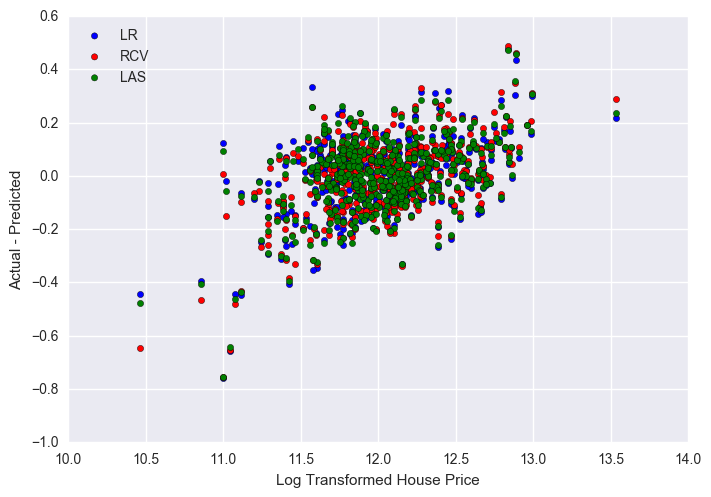

In [58]:
#Residuals comparison
fig_r, ax = plt.subplots()
ax.scatter(y,y-lr.predict(x),label = 'LR')
ax.scatter(y,y-rcv.predict(x),c='r',label = 'RCV')
ax.scatter(y,y-las.predict(x),c='g',label = 'LAS')
ax.set_xlabel('Log Transformed House Price')
ax.set_ylabel('Actual - Predicted')
ax.legend(loc=2)

In [59]:
#Submit the solutions. I add the top 100 catagorical features
#and selected a total of 67 features in the training set,
#this resulted in a score of approximately 0.135 for all
#three models.
test = pd.read_csv("test.csv")
test.index = test['Id']
testDummies = pd.get_dummies(test[categorical]).columns.values.tolist()
test = pd.get_dummies(test)
x_test = dataprep(test,finalNumerical,testDummies)

lr.fit(modelData[finalFeats],modelData['SalePrice'])
rcv.fit(modelData[finalFeats],modelData['SalePrice'])
las.fit(modelData[finalFeats],modelData['SalePrice'])

predlr = lr.predict(x_test[finalFeats])
predrcv = rcv.predict(x_test[finalFeats])
predlas = las.predict(x_test[finalFeats])

fn = 'las_20161030_1.csv'
test['SalePrice_LR'] = np.expm1(predlr)
test['SalePrice_RCV'] = np.expm1(predrcv)
test['SalePrice_LAS'] = np.expm1(predlas)
print(test[['SalePrice_LR'
            ,'SalePrice_RCV'
            ,'SalePrice_LAS']].head()
      )


         SalePrice_LR  SalePrice_RCV  SalePrice_LAS
Id                                                 
1461.0  127887.305866  126501.432227  126417.008547
1462.0  160556.720439  161304.299141  162775.356076
1463.0  177639.598993  179314.563280  174732.877318
1464.0  181671.714955  174878.648322  173370.399823
1465.0  184906.350532  189725.846623  193233.002026


In [62]:
#test["SalePrice"] = test["SalePrice_LR"]
#test = test[["Id", "SalePrice_LR"]] 

#test[list("Id")] = test[list("Id")].astype(int)

# test["Id"] = test["Id"].astype(int)

# for row in test:
#     print(row)
    #row["Id"] = int(row["Id"])
#print(test.head())

#test["Id"] = test["Id"].astype(int)

test.Id = test.Id.astype(int).fillna(0.0)

#test = test[["Id", "SalePrice_LR"]] 
test.to_csv("gary.csv", index=False)